In [ ]:
# default_exp stft

In [2]:
#hide 
%load_ext autoreload
%autoreload 2

In [3]:
#export
from rtma.imports import *
from rtma.core import *
from rtma.signal import *
from rtma.fft import *

# STFT

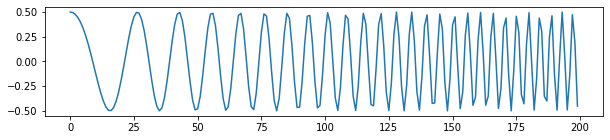

In [4]:
sr = 100
amp = 0.5
n_fft = 128

freq = [sr / n_fft * f for f in [3, 17]]
num_samples = 200
x = gen_sinusoid(amp, freq=freq, sample_rate=sr, num_samples=num_samples)
plot(x)

In [5]:
n_fft = 128
m = 97
h = 48

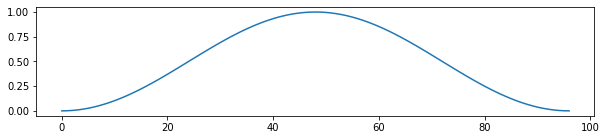

In [6]:
w = get_window('hann', m, False)
plot(w)

assert check_COLA(w, nperseg=m, noverlap=m-h)

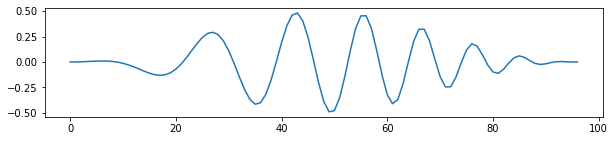

In [7]:
wx = x[:m] * w
plot(wx)

In [8]:
#export
def gen_frames(x, n_window, n_hop, window = None):
    n_overlap = n_window - n_hop
    x = np.pad(x, (n_overlap, 0), mode='constant')
    i = 0
    while i < x.size:
        frame = x[i:i+n_window]
        if frame.size < n_window:
            frame = np.pad(frame, (0, n_window-frame.size), mode='constant')
        if window is not None:
            frame = frame * window
        yield frame
        i += n_hop

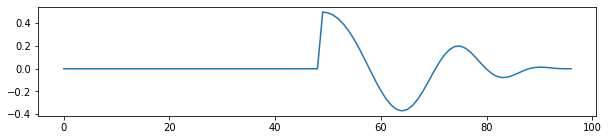

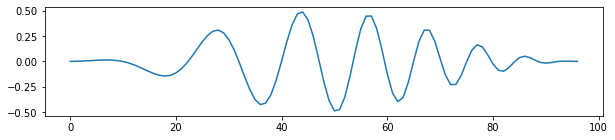

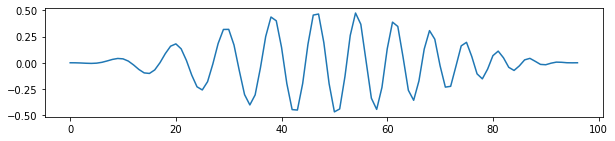

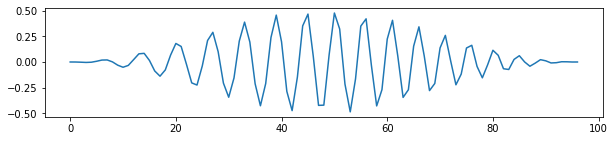

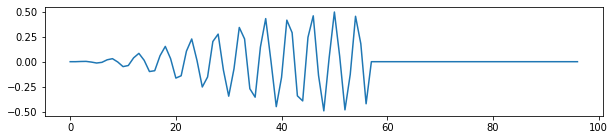

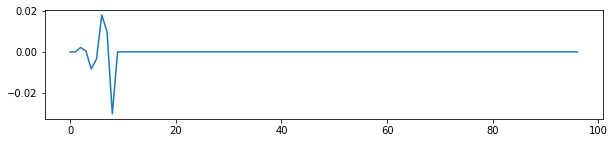

In [9]:
frames = list(gen_frames(x, m, h, w))
for frame in frames:
    plot(frame)

In [10]:
def synth_frames(frames, n_hop, n_samples: int = None):
    frames = list(frames)
    n_frames = len(frames) # TODO: make synth_frames a generator ?
    n_window = frames[0].size
    
    buffer_len = n_window + n_hop*(n_frames-1)
    y = np.zeros(buffer_len, dtype=frames[0].dtype)
    
    for i, frame in enumerate(frames):
        offset_i = i*n_hop
        y[offset_i:offset_i+m] += frame\

    n_overlap = n_window - n_hop
    y = y[n_overlap:]
    if n_samples is not None:
        y = y[:n_samples]
    return y
    
y = synth_frames(frames, h, x.size)

In [11]:
np.isclose(x, y).all()

True

In [12]:
def stft(x, n_fft, n_hop, window):
    n_window = window.size
    for x_i in gen_frames(x, n_window=n_window, n_hop=n_hop, window=window):
        m_x, p_x = fft_analysis(x_i, n_fft)
        yield m_x, p_x
    

In [13]:
def istft(spectrum, n_hop, n_window, n_samples: int = None):
    frames = (fft_synthesis(m_x, p_x, n_window) for m_x, p_x in spectrum)
    return synth_frames(frames, n_hop, n_samples)

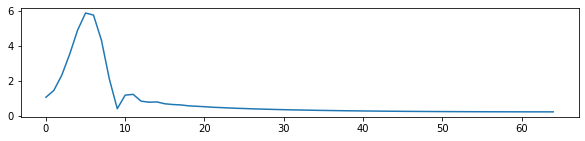

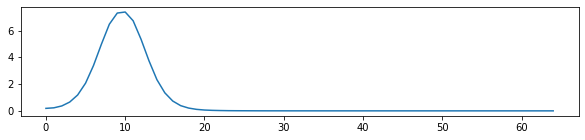

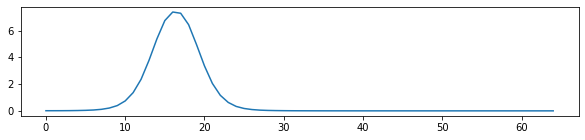

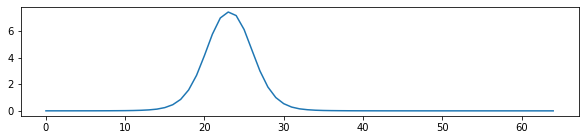

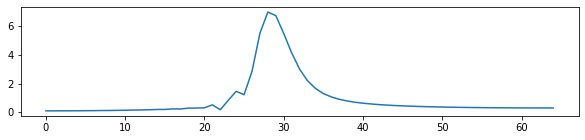

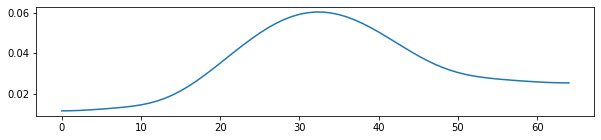

In [14]:
for m_x, p_x in stft(x, n_fft, h, w):
    plot(m_x)

In [15]:
spectrum = list(stft(x, n_fft, h, w))

In [16]:
m_xs, p_xs = (np.stack(s) for s in zip(*spectrum))

In [17]:
m_xs.shape, p_xs.shape

((6, 65), (6, 65))

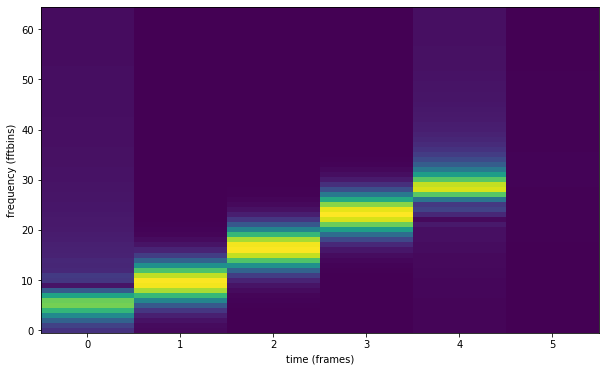

In [18]:
plot_mags(m_xs)

In [19]:
x.shape

(200,)

In [20]:
y = istft(spectrum, h, m, x.size)

In [21]:
np.isclose(x, y).all()

True

In [22]:
y = istft(stft(x, n_fft, h, w), h, m, x.size)

In [23]:
np.isclose(x, y).all()

True

### Real Example

In [24]:
fn = "data/E_octaves_both.wav"
x, sr = load_audio(fn)

In [25]:
n_fft = 4096
h = 1024
m = h*2 + 1

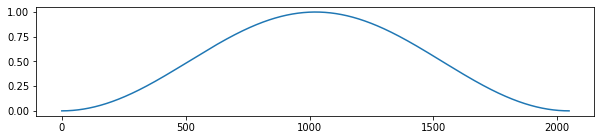

In [26]:
w = get_window('hann', m, False)
plot(w)

assert check_COLA(w, nperseg=m, noverlap=m-h)

In [27]:
spectrum = list(stft(x, n_fft, h, w))

In [28]:
m_xs, p_xs = (np.stack(s) for s in zip(*spectrum))

In [29]:
mx_db = 20.0 * np.log10(m_xs)

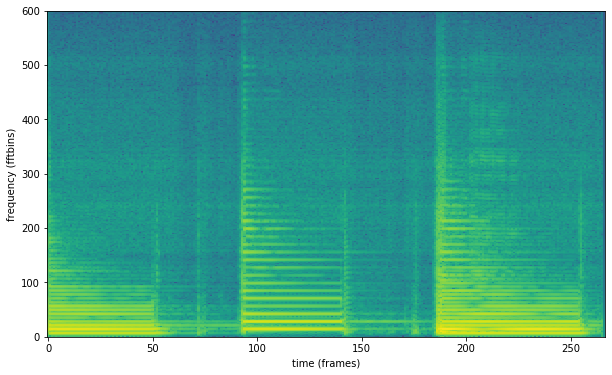

In [30]:
plot_mags(mx_db, max_bin=600)

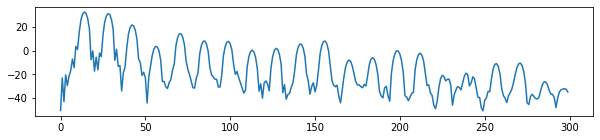

In [31]:
plot(mx_db[100,:300])

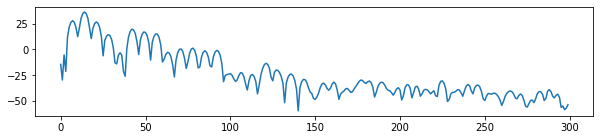

In [32]:
plot(mx_db[20,:300])

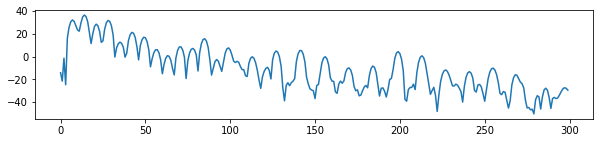

In [33]:
plot(mx_db[200,:300])

In [34]:
y = istft(spectrum, h, m, x.size)
np.isclose(x, y).all()

True

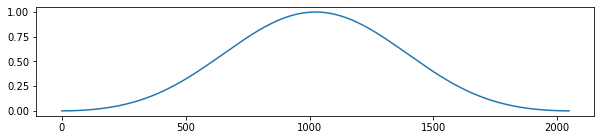

In [35]:
n_fft = 4096
h = 512
m = h*4 + 1
w = get_window('blackman', m, False)
plot(w)

assert check_COLA(w, nperseg=m, noverlap=m-h)

In [36]:
print(m)

2049


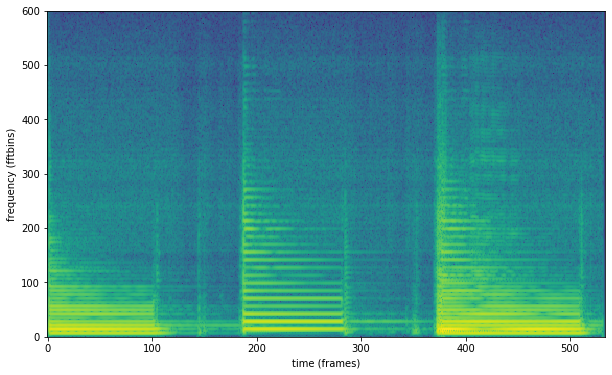

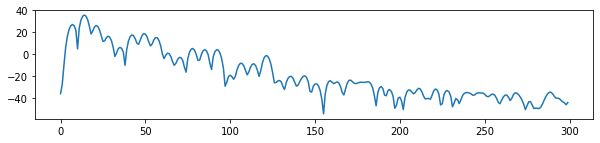

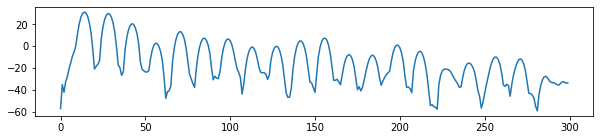

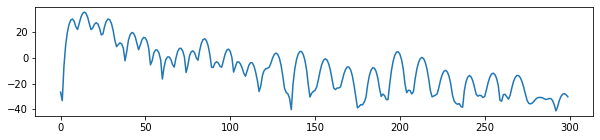

In [37]:
spectrum = list(stft(x, n_fft, h, w))
m_xs, p_xs = (np.stack(s) for s in zip(*spectrum))
mx_db = 20.0 * np.log10(m_xs)
plot_mags(mx_db, max_bin=600)
plot(mx_db[20,:300])
plot(mx_db[200,:300])
plot(mx_db[400,:300])